In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer,MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import xgboost

plt.rcParams['font.family'] = 'AppleGothic' # 한글 폰트 설정
plt.rc('font', size=15)
plt.rcParams['figure.figsize'] = (12, 12) # 그래프 크기 설정

In [129]:
import pickle

In [2]:
df=pd.read_csv('./중고차데이터최종.csv',encoding='cp949')

In [3]:
df=df.drop(['Unnamed: 0','index'],axis=1)

In [4]:
df[df['생산지']=='국산차']['제조회사'].unique()

array(['쌍용', '기아', '쉐보레', '현대', '제네시스', '르노삼성', '대형트럭(2톤이상)'],
      dtype=object)

# 모델링 전 전처리

In [5]:
colors=['흰색','검정색','쥐색','은색','회색','진주색','청색','다크그레이색']

In [6]:
df['색상']=df['색상'].apply(lambda x : x if x in colors else '기타')

In [7]:
df=pd.concat([df,pd.get_dummies(df['색상'])],axis=1).drop('색상',axis=1)

In [8]:
df=pd.concat([df,pd.get_dummies(df['연료'])],axis=1).drop('연료',axis=1)
df=pd.concat([df,pd.get_dummies(df['변속기'])],axis=1).drop('변속기',axis=1)
#df=pd.concat([df,pd.get_dummies(df['제조회사'])],axis=1).drop('제조회사',axis=1)
df=pd.concat([df,pd.get_dummies(df['구동방식'])],axis=1).drop('구동방식',axis=1)
#df=pd.concat([df,pd.get_dummies(df['차종'])],axis=1).drop('차종',axis=1)

In [9]:
scaler=MinMaxScaler()
scaler2=StandardScaler()

In [10]:
df['연식']=scaler.fit_transform(df['연식'].values.reshape(-1,1))
#df['배기량']=scaler.fit_transform(df['배기량'].values.reshape(-1,1))
#df['주행거리']=scaler2.fit_transform(df['주행거리'].values.reshape(-1,1))

In [11]:
df

,이름,제조회사,모델명,세부모델,가격,배기량,연식,주행거리,차종,압류/저당,...,수소전기,전기,하이브리드,휘발유,휘발유+LPG,수동,자동,4륜,전륜,후륜
0,쌍용 티볼리 LX 2WD 세부등급 없음,쌍용,티볼리,티볼리,1360,1597,0.81250,40007,SUV,0,...,0,0,0,1,0,0,1,0,1,0
1,기아 올 뉴 모닝 럭셔리,기아,모닝,올 뉴 모닝 (11~15년),670,998,0.65625,48280,경차,0,...,0,0,0,1,0,0,1,0,1,0
2,쉐보레(GM대우) 알페온 EL300 슈프림,쉐보레,알페온,알페온,900,2997,0.65625,69377,대형차,0,...,0,0,0,1,0,0,1,0,1,0
3,쌍용 렉스턴 스포츠 디젤 2.2 4WD 노블레스,쌍용,렉스턴,렉스턴 스포츠 칸,2420,2157,0.87500,41820,SUV,0,...,0,0,0,0,0,0,1,1,0,0
4,쉐보레(GM대우) 더 뉴 말리부 1.3 터보 프리미어 세부등급없음,쉐보레,말리부,더 뉴 말리부,2240,1341,0.93750,29856,중형차,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14552,아우디 S4,아우디,S4,S4,1330,2995,0.62500,87219,중형차,0,...,0,0,0,1,0,0,1,0,0,1
14553,기아 스포티지R,기아,스포티지,스포티지R (10~13년),800,1995,0.62500,129430,SUV,0,...,0,0,0,0,0,0,1,0,1,0
14554,폭스바겐 티구안(1세대),폭스바겐,티구안,티구안 1세대,1030,2000,0.71875,167662,SUV,0,...,0,0,0,0,0,0,1,0,1,0
14555,제네시스 EQ900,제네시스,제네시스,EQ900,3390,5038,0.78125,172795,대형차,0,...,0,0,0,1,0,0,1,0,0,1


In [12]:
a=['경승합차','승합차']
b=['SUV','경차','대형차','중형차','소형차','스포츠카','기타','준중형차']
c=['화물차','특장차']

In [13]:
def chg(x):
    if x in a:
        return '승합차'
    elif x in b :
        return '승용차'
    elif x in c:
        return '화물차'

In [14]:
df['차종']=df['차종'].apply(chg)

# 국산차/외제차

In [15]:
df_made=pd.concat([df,pd.get_dummies(df['차종'])],axis=1).drop('차종',axis=1)

In [16]:
df_korean=df_made[df_made['생산지']=='국산차']
df_korean=df_korean.drop('생산지',axis=1)
df_korean=pd.concat([df_korean,pd.get_dummies(df_korean['제조회사'])],axis=1).drop('제조회사',axis=1)

In [17]:
df_foreign=df_made[df_made['생산지']=='외제차']
df_foreign=df_foreign.drop('생산지',axis=1)
df_foreign=pd.concat([df_foreign,pd.get_dummies(df_foreign['제조회사'])],axis=1).drop('제조회사',axis=1)

In [18]:
df_korean=df_korean.drop(['이름','모델명','세부모델'],axis=1)

In [19]:
df_korean['target']=df_korean['가격']/df_korean['신차가격']

In [20]:
df_korean=df_korean.drop(df_korean[df_korean['target']>1].index)

In [21]:
df_korean=df_korean.drop(['가격','신차가격','기타'],axis=1)

In [22]:
df_korean.dropna(inplace=True)

Text(0.5, 1.0, 'Q-Q Plot')

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


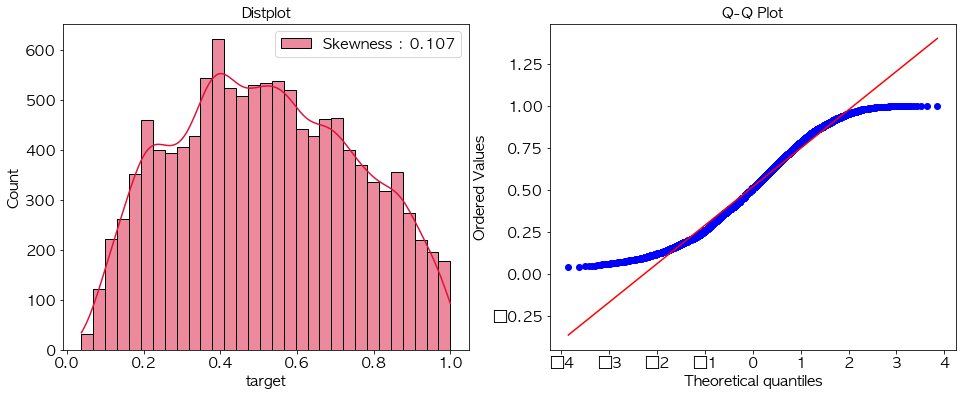

In [23]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.histplot(df_korean['target'], ax = ax1, kde=True,color='crimson', label='Skewness : {:.3f}'.format(df_korean['target'].skew()))
ax1.legend(loc='best', fontsize = 15)
ax1.set_title('Distplot', fontsize = 15)

stats.probplot(df_korean['target'],dist=stats.norm,plot=ax2)
plt.title("Q-Q Plot", fontsize = 15)

In [24]:
df_foreign=df_foreign.drop(['이름','모델명','세부모델'],axis=1)
df_foreign['target']=df_foreign['가격']/df_foreign['신차가격']
df_foreign=df_foreign.drop(df_foreign[df_foreign['target']>1].index)
df_foreign=df_foreign.drop(['가격','신차가격','기타'],axis=1)
df_foreign.dropna(inplace=True)

Text(0.5, 1.0, 'Q-Q Plot')

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


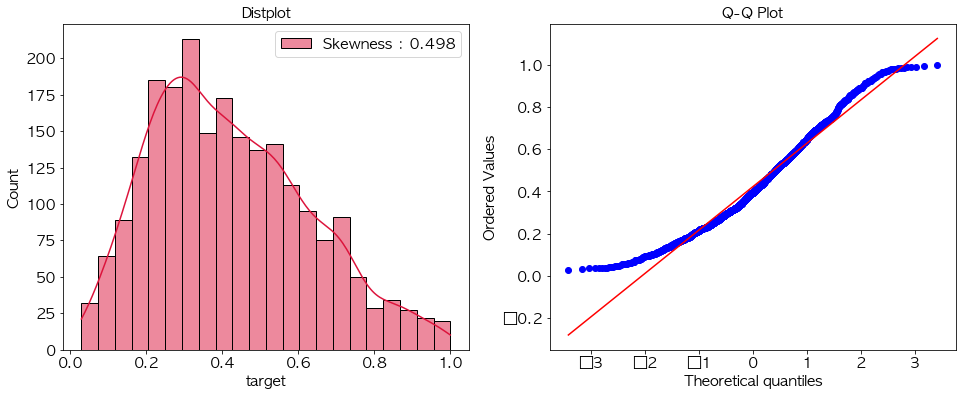

In [25]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.histplot(df_foreign['target'], ax = ax1, kde=True,color='crimson', label='Skewness : {:.3f}'.format(df_foreign['target'].skew()))
ax1.legend(loc='best', fontsize = 15)
ax1.set_title('Distplot', fontsize = 15)

stats.probplot(df_foreign['target'],dist=stats.norm,plot=ax2)
plt.title("Q-Q Plot", fontsize = 15)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,Lasso
import tensorflow as tf

In [27]:
x=df_korean.drop('target',axis=1)
y=df_korean['target']

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

In [29]:
len(x_train.columns)

37

In [30]:
xf=df_foreign.drop('target',axis=1)
yf=df_foreign['target']

In [31]:
x_trainf,x_testf,y_trainf,y_testf=train_test_split(xf,yf,test_size=0.2,random_state=2)

In [32]:
len(x_trainf.columns)

66

In [33]:
F_statistic, pVal = stats.f_oneway(df_korean['target'],df_foreign['target'])

print('중고차 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
if pVal < 0.05:
    print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

중고차 데이터의 일원분산분석 결과 : F=330.0, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


## 선형회귀, Ridge, Lasso

### 선형회귀 - 국산차

In [34]:
model=LinearRegression()

In [35]:
model.fit(x_train,y_train)

LinearRegression()

In [36]:
model.score(x_test,y_test)

0.37575393660027956

In [37]:
mean_squared_error(y_test, model.predict(x_test))**0.5

0.1807057808997959

In [38]:
mean_absolute_error(y_test, model.predict(x_test))

0.14153541834664535

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


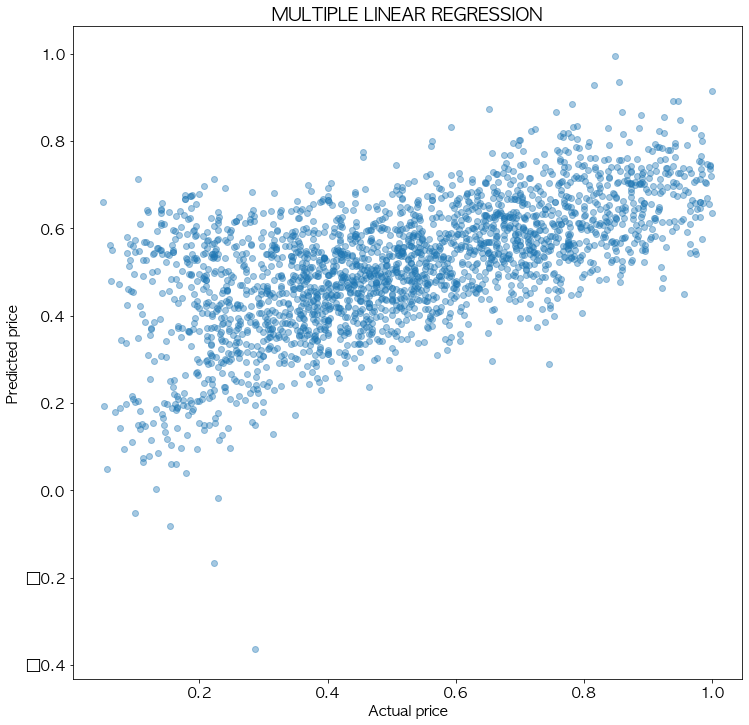

In [39]:
plt.scatter(y_test, model.predict(x_test), alpha=0.4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
#plt.xlim(0,1.5)
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [40]:
model.intercept_,model.coef_

(-0.3446348471356607,
 array([-4.59998360e-05,  1.29133783e+00,  5.42323360e-07, -1.87811572e-13,
        -1.63301326e-02, -1.05155743e-01, -4.50739040e-02, -1.02895103e-01,
        -4.58350172e-02,  5.10047332e-02,  6.87530381e-02,  1.84281475e-02,
        -2.08192098e-02, -5.36977350e-02, -1.90620578e-02,  1.38028173e-02,
         6.49480469e-15, -1.78699353e-01,  6.99544208e-02,  3.76481502e-02,
         4.13220336e-02,  3.50339887e-02,  1.82986326e-02, -1.82986326e-02,
         1.22819473e-01, -1.64886153e-02, -1.06330858e-01, -8.86275829e-02,
         8.48172772e-02,  3.81030576e-03,  2.11706981e-02,  5.13637629e-03,
        -9.98558508e-02,  3.71922772e-02,  6.90852388e-02, -4.41416247e-02,
         1.14128851e-02]))

### 선형회귀 - 외제차

In [41]:
modelf=LinearRegression()

In [42]:
modelf.fit(x_trainf,y_trainf)

LinearRegression()

In [43]:
modelf.score(x_testf,y_testf)

0.7767248807453927

In [44]:
mean_squared_error(y_testf, modelf.predict(x_testf))**0.5

0.09300362010513416

In [45]:
mean_absolute_error(y_testf, modelf.predict(x_testf))**0.5

0.2595211547554138

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


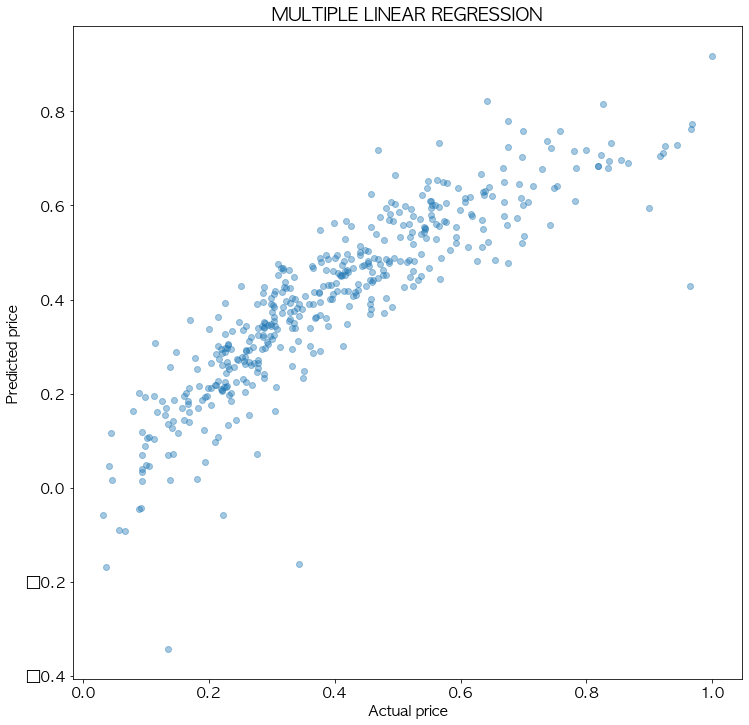

In [46]:
plt.scatter(y_testf, modelf.predict(x_testf), alpha=0.4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
#plt.xlim(0,1.5)
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

### Lasso - 국산차

In [47]:
model_lasso=Lasso()

In [48]:
model_lasso.fit(x_train,y_train)

Lasso()

In [49]:
model_lasso.score(x_test,y_test)

0.07102055514388816

In [50]:
mean_squared_error(y_test, model_lasso.predict(x_test))**0.5

0.22044344649596598

In [51]:
mean_absolute_error(y_test, model_lasso.predict(x_test))

0.18363467086301313

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


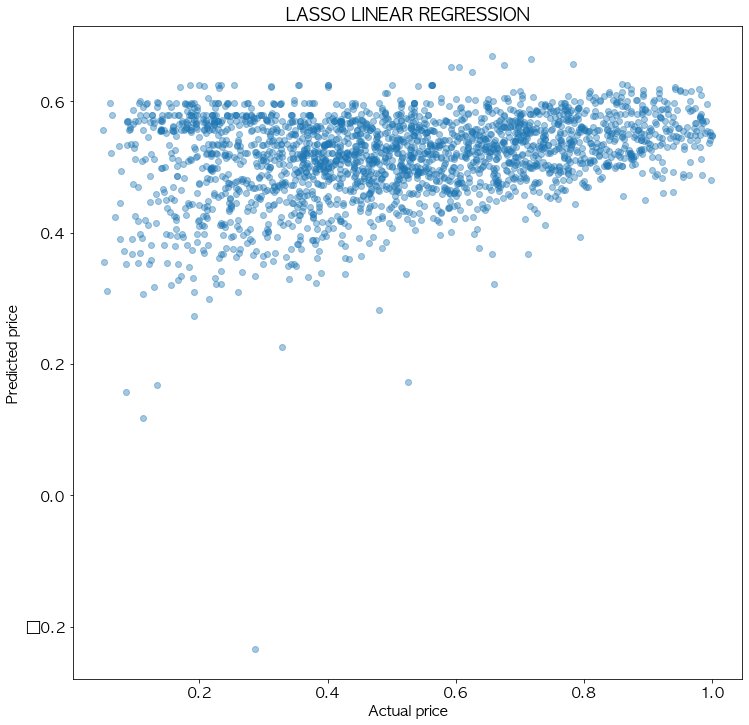

In [52]:
plt.scatter(y_test, model_lasso.predict(x_test), alpha=0.4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("LASSO LINEAR REGRESSION")
plt.show()

### Lasso - 외제차

In [53]:
modelf_lasso=Lasso()

In [54]:
modelf_lasso.fit(x_trainf,y_trainf)

Lasso()

In [55]:
modelf_lasso.score(x_testf,y_testf)

0.54512570220494

In [56]:
mean_squared_error(y_testf, modelf_lasso.predict(x_testf))**0.5

0.13274720556125674

In [57]:
mean_absolute_error(y_testf, modelf_lasso.predict(x_testf))

0.10190581749541071

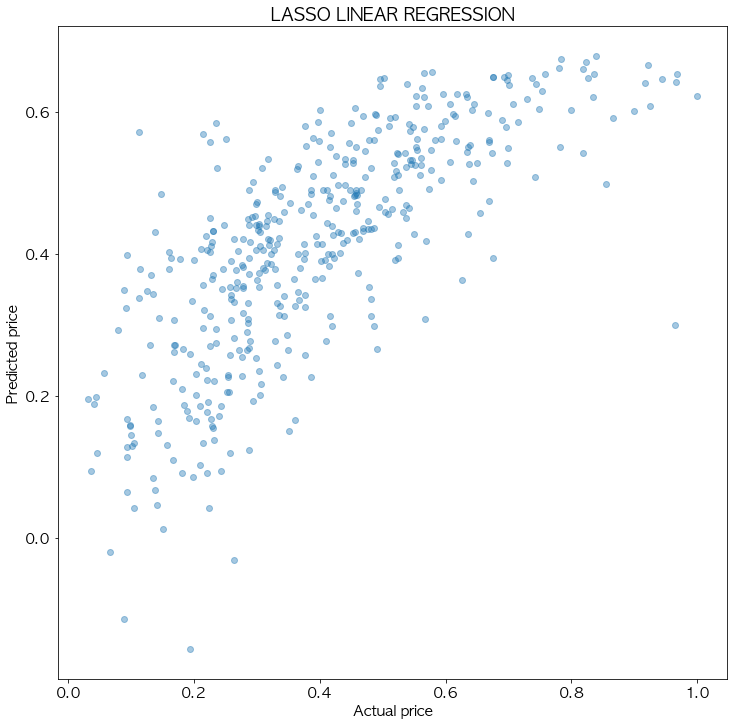

In [58]:
plt.scatter(y_testf, modelf_lasso.predict(x_testf), alpha=0.4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("LASSO LINEAR REGRESSION")
plt.show()

### Ridge-국산차

In [59]:
model_ridge=Ridge()

In [60]:
model_ridge.fit(x_train,y_train)

Ridge()

In [61]:
model_ridge.score(x_test,y_test)

0.3758624060061351

In [62]:
mean_squared_error(y_test, model_ridge.predict(x_test))**0.5

0.18069008044016555

In [63]:
mean_absolute_error(y_test, model_ridge.predict(x_test))

0.1415210881208547

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


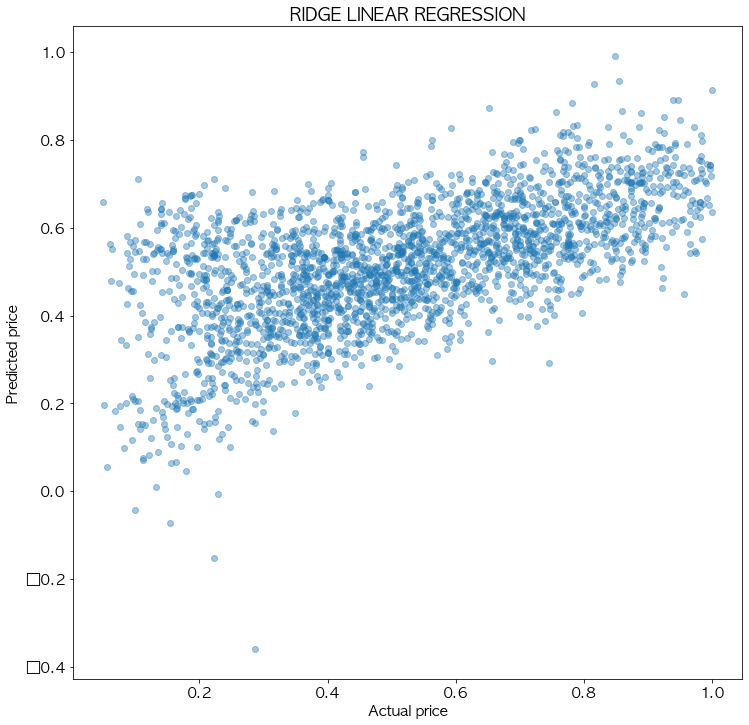

In [64]:
plt.scatter(y_test, model_ridge.predict(x_test), alpha=0.4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("RIDGE LINEAR REGRESSION")
plt.show()

### Ridge-외제차

In [65]:
modelf_ridge=Ridge()

In [66]:
modelf_ridge.fit(x_trainf,y_trainf)

Ridge()

In [67]:
modelf_ridge.score(x_testf,y_testf)

0.7807609091382031

In [68]:
mean_squared_error(y_testf, modelf_ridge.predict(x_testf))**0.5

0.09215919758167378

In [69]:
mean_absolute_error(y_testf, modelf_ridge.predict(x_testf))

0.06832890516523414

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


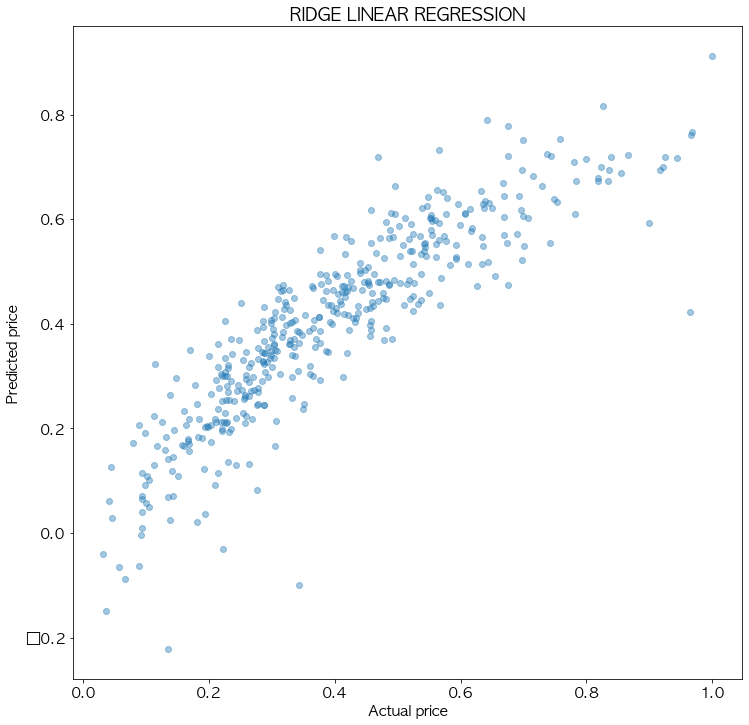

In [70]:
plt.scatter(y_testf, modelf_ridge.predict(x_testf), alpha=0.4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("RIDGE LINEAR REGRESSION")
plt.show()

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


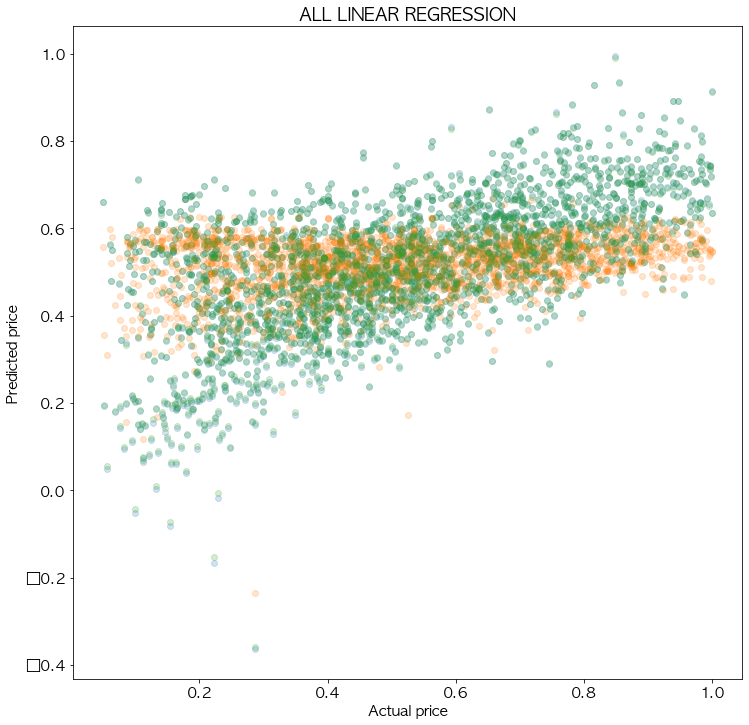

In [71]:
plt.scatter(y_test, model.predict(x_test), alpha=0.2)
plt.scatter(y_test, model_lasso.predict(x_test), alpha=0.2)
plt.scatter(y_test, model_ridge.predict(x_test), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("ALL LINEAR REGRESSION")
plt.show()

## 의사결정나무

### 의사결정나무 - 국산차

In [72]:
from sklearn.tree import DecisionTreeRegressor

In [73]:
tree_model=DecisionTreeRegressor(random_state=0,criterion='absolute_error').fit(x_train,y_train)
tree_model.score(x_train,y_train),model.score(x_test,y_test)

(0.9959610307055904, 0.37575393660027956)

In [74]:
mean_squared_error(y_test, tree_model.predict(x_test))**0.5

0.13337471213908114

In [75]:
mean_absolute_error(y_test,tree_model.predict(x_test))

0.09321399711600627

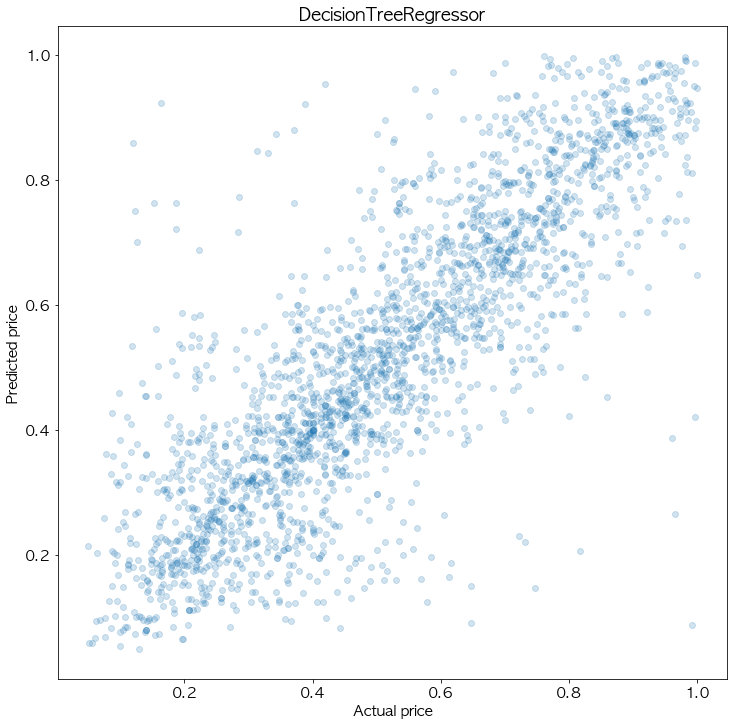

In [76]:
plt.scatter(y_test, tree_model.predict(x_test), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("DecisionTreeRegressor")

plt.show()

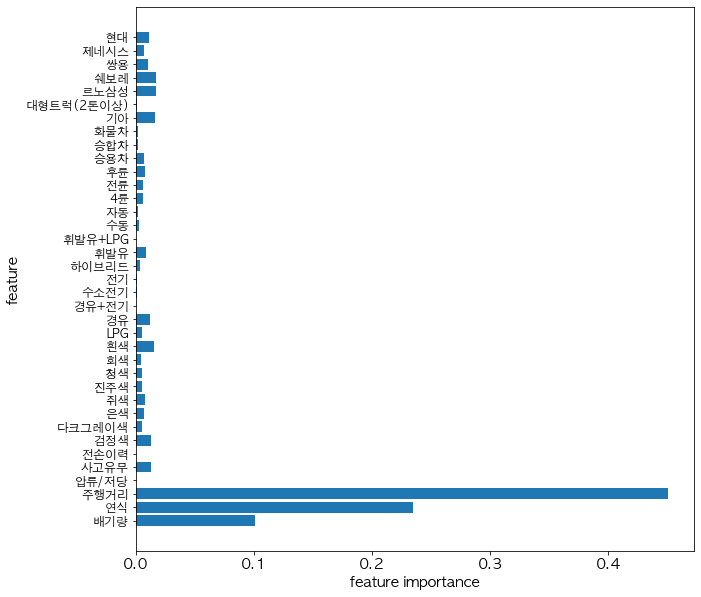

In [77]:
feature_importance = tree_model.feature_importances_
feature_name = list(x_train.columns)
n_feature = x_train.shape[1]
idx = np.arange(n_feature)
plt.rcParams["figure.figsize"] = (10,10)
plt.barh(idx, feature_importance, align='center')
plt.yticks(idx, feature_name, size=12)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

### 의사결정나무 - 외제차

In [78]:
tree_modelf=DecisionTreeRegressor(random_state=0,criterion='absolute_error').fit(x_trainf,y_trainf)
tree_modelf.score(x_trainf,y_trainf),tree_modelf.score(x_testf,y_testf)

(0.9999124554488856, 0.7266984821388561)

In [79]:
mean_squared_error(y_testf, tree_modelf.predict(x_testf))**0.5

0.1028965255319034

In [80]:
mean_absolute_error(y_testf,tree_modelf.predict(x_testf))

0.07264880976797781

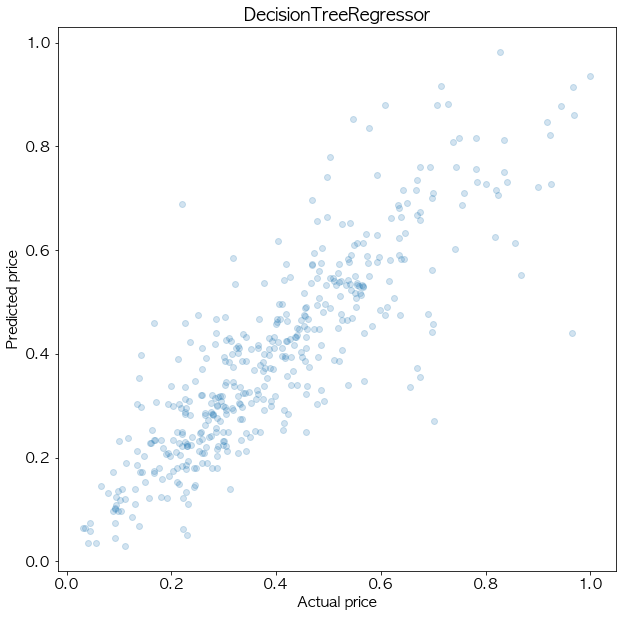

In [81]:
plt.scatter(y_testf, tree_modelf.predict(x_testf), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("DecisionTreeRegressor")

plt.show()

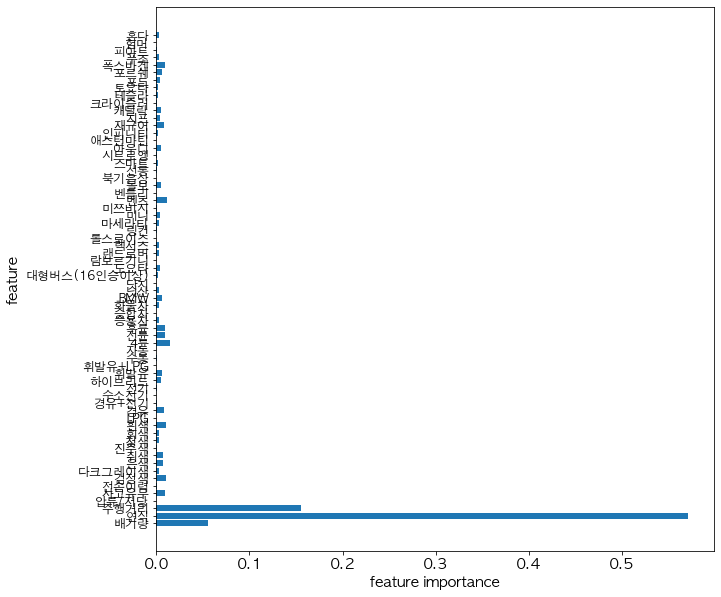

In [82]:
feature_importancef = tree_modelf.feature_importances_
feature_namef = list(x_trainf.columns)
n_featuref = x_trainf.shape[1]
idx = np.arange(n_featuref)
plt.rcParams["figure.figsize"] = (10,10)
plt.barh(idx, feature_importancef, align='center')
plt.yticks(idx, feature_namef, size=12)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

## Random Forest

### Random Forest - 국산차

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
model_forest=RandomForestRegressor()

In [85]:
model_forest.fit(x_train,y_train)

RandomForestRegressor()

In [86]:
mean_squared_error(y_test, model_forest.predict(x_test))**0.5

0.10321841424773563

In [87]:
mean_absolute_error(y_test,model_forest.predict(x_test))

0.07196818290008591

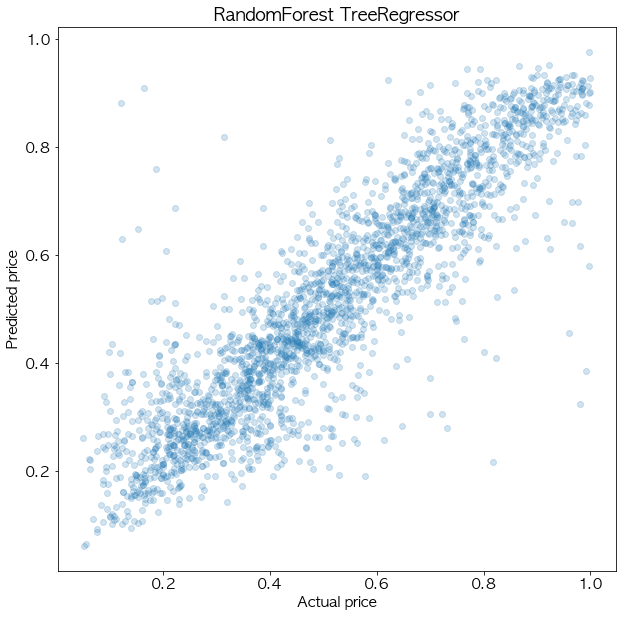

In [88]:
plt.scatter(y_test, model_forest.predict(x_test), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("RandomForest TreeRegressor")

plt.show()

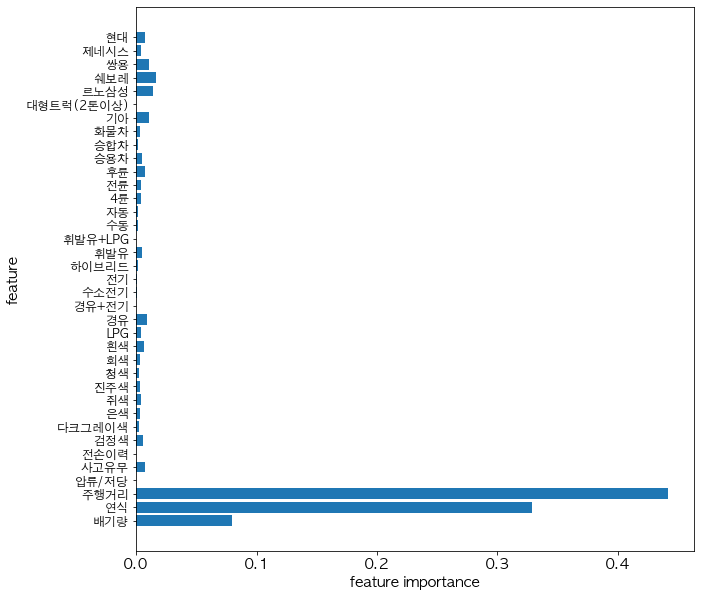

In [89]:
feature_importance = model_forest.feature_importances_
feature_name = list(x_train.columns)
n_feature = x_train.shape[1]
idx = np.arange(n_feature)
plt.rcParams["figure.figsize"] = (10,10)
plt.barh(idx, feature_importance, align='center')
plt.yticks(idx, feature_name, size=12)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

### Random Forest - 외제차

In [90]:
model_forest_f=RandomForestRegressor()

In [91]:
model_forest_f.fit(x_trainf,y_trainf)

RandomForestRegressor()

In [92]:
mean_squared_error(y_testf, model_forest_f.predict(x_testf))**0.5

0.0811215207420325

In [93]:
mean_absolute_error(y_testf,model_forest_f.predict(x_testf))

0.05674554108193784

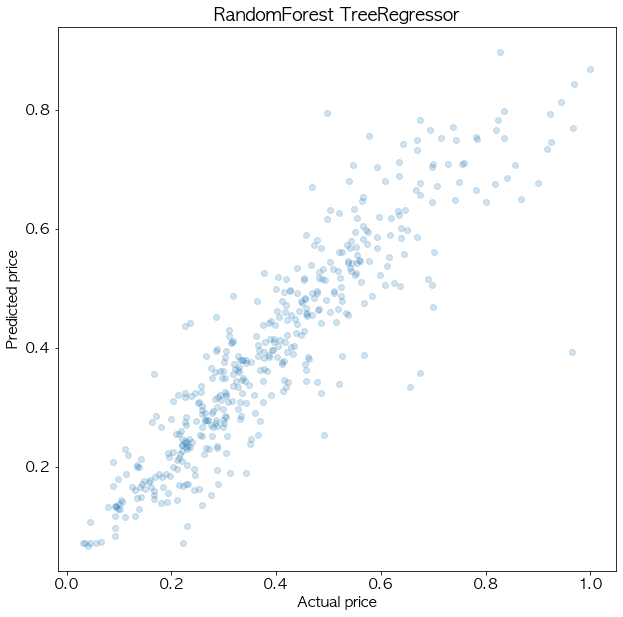

In [94]:
plt.scatter(y_testf, model_forest_f.predict(x_testf), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("RandomForest TreeRegressor")

plt.show()

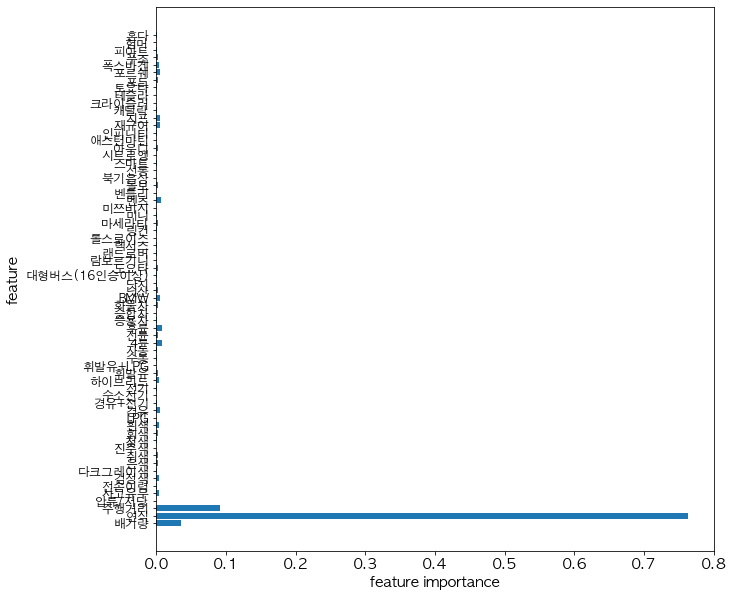

In [95]:
feature_importance = model_forest_f.feature_importances_
feature_name = list(x_trainf.columns)
n_feature = x_trainf.shape[1]
idx = np.arange(n_feature)
plt.rcParams["figure.figsize"] = (10,10)
plt.barh(idx, feature_importance, align='center')
plt.yticks(idx, feature_name, size=12)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

## xgboost

### xgboost 국산차

In [96]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)

In [97]:
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [98]:
xgb_model.score(x_test,y_test)

0.8260525380393308

In [99]:
mean_squared_error(y_test, xgb_model.predict(x_test))**0.5

0.09539007455246462

In [100]:
mean_absolute_error(y_test, xgb_model.predict(x_test))

0.06889772390014903

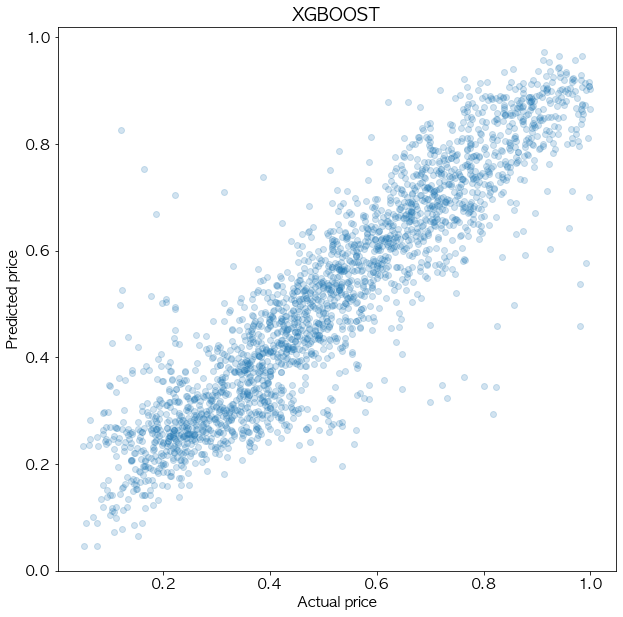

In [101]:
plt.scatter(y_test, xgb_model.predict(x_test), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("XGBOOST")

plt.show()

In [130]:
pickle.dump(xgb_model, open('x_model.model', 'wb'))

### xgboost 외제차

In [103]:
xgb_modelf = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)

In [104]:
xgb_modelf.fit(x_trainf,y_trainf)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [105]:
xgb_modelf.score(x_testf,y_testf)

0.8491853401581314

In [106]:
mean_squared_error(y_testf, xgb_modelf.predict(x_testf))**0.5

0.07643661885609299

In [107]:
mean_absolute_error(y_testf, xgb_modelf.predict(x_testf))

0.05334588264674839

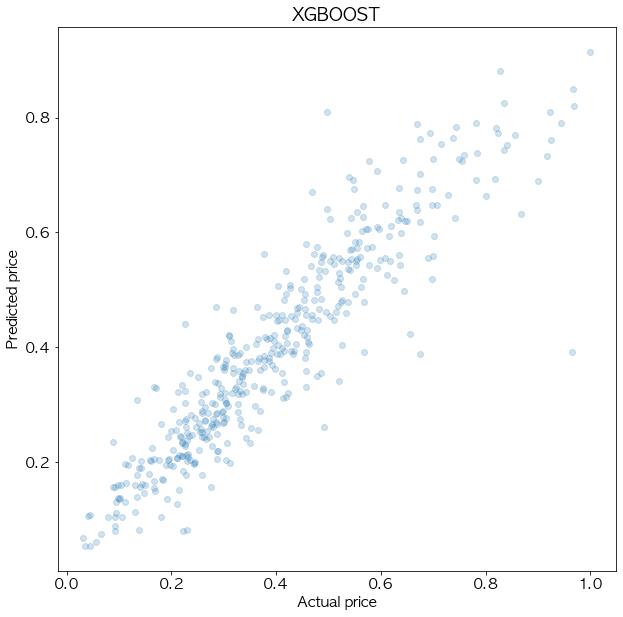

In [108]:
plt.scatter(y_testf, xgb_modelf.predict(x_testf), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("XGBOOST")

plt.show()

In [109]:
xgb_modelf.save_model('foreign_car_xgb.model')

## Tensorflow

In [110]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [111]:
model=models.Sequential()
model.add(layers.Dense(30,activation='relu',input_shape=(37,)))
model.add(layers.Dense(30,activation='relu'))
model.add(layers.Dense(1,activation='linear'))

In [112]:
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [113]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1140      
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [114]:
history=model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=50,verbose=0)

2022-05-19 10:22:05.483935: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [115]:
mean_absolute_error(y_test,model.predict(x_test))

0.771131158535604

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


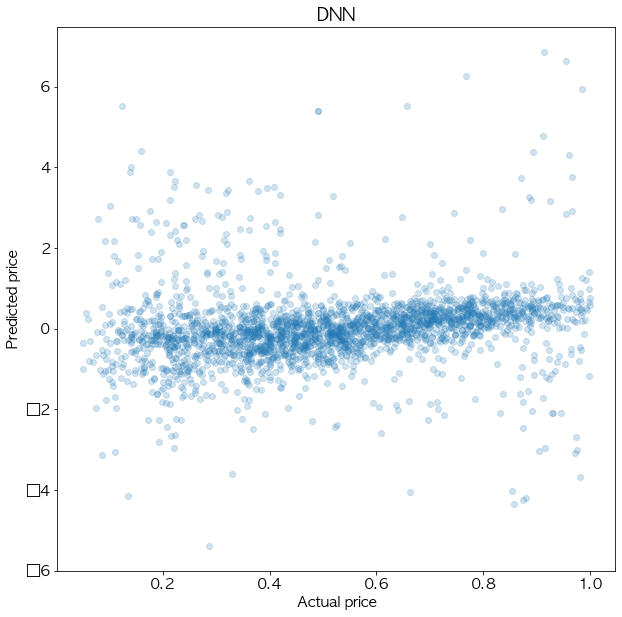

In [116]:
plt.scatter(y_test, model.predict(x_test), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("DNN")

plt.show()

In [117]:
model2=models.Sequential()
model2.add(layers.Dense(16,activation='relu',input_shape=(66,)))
model2.add(layers.Dense(16,activation='relu'))
model2.add(layers.Dense(1,activation='linear'))
model2.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [118]:
history2=model2.fit(x_trainf,y_trainf,epochs=50,validation_split=0.2,batch_size=50,verbose=0)

In [119]:
mean_absolute_error(y_testf,model2.predict(x_testf))

1.153037926760998

/Users/kim/miniforge3/envs/dp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


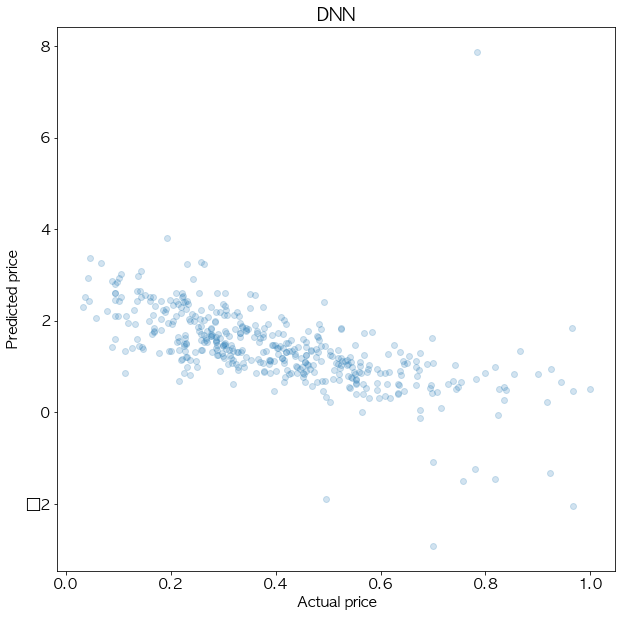

In [120]:
plt.scatter(y_testf, model2.predict(x_testf), alpha=0.2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("DNN")

plt.show()

14557